In [1]:
import pandas as pd
from pathlib import Path

# Import Data
We need to concatenate all readings from all csvs into a single DataFrame.

In [2]:
csv_files = list(Path('/content/measurements/').glob('*.csv'))
dfs = []

for csv_file in csv_files:
    df_temp = pd.read_csv(csv_file)
    dfs.append(df_temp)

df = pd.concat(dfs, ignore_index=True)
print(f"Successfully loaded and concatenated {len(csv_files)} CSV files into a single DataFrame.")
print(f"The final DataFrame has {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

Successfully loaded and concatenated 54 CSV files into a single DataFrame.
The final DataFrame has 1901308 rows and 5 columns.


,timestamp_iso8601,sensor,quantity,value,unit
0,2025-09-17T00:00:33Z,veml7700,lux_lx,0.000000,lx
1,2025-09-17T00:00:33Z,bme280,temperature_c,26.279278,degC
2,2025-09-17T00:00:33Z,bme280,pressure_pa,100920.804688,Pa
3,2025-09-17T00:00:33Z,bme280,humidity_pct,97.695190,pct
4,2025-09-17T00:00:33Z,lm393,is_raining,0.000000,NaN


In [3]:
df = df[["timestamp_iso8601", "quantity", "value"]]
df.head()

,timestamp_iso8601,quantity,value
0,2025-09-17T00:00:33Z,lux_lx,0.000000
1,2025-09-17T00:00:33Z,temperature_c,26.279278
2,2025-09-17T00:00:33Z,pressure_pa,100920.804688
3,2025-09-17T00:00:33Z,humidity_pct,97.695190
4,2025-09-17T00:00:33Z,is_raining,0.000000


# Data Pre-Processing

## Pivoting - Reformating the data into multiple columns
We make each quantity (measurement type e.g. lux, pressure, temperature) its own column, so each row will have one value per quantity instead of one row per quantity.

In [4]:
df["quantity"].value_counts()

,count
quantity,
lux_lx,382940
is_raining,382831
pressure_pa,378835
temperature_c,378458
humidity_pct,378243


In [5]:
df = df.pivot_table(values='value', index='timestamp_iso8601',
                       columns='quantity', aggfunc="mean").reset_index()
print(df.columns.name)
df.head()

quantity


quantity,timestamp_iso8601,humidity_pct,is_raining,lux_lx,pressure_pa,temperature_c
0,2025-09-04T22:13:36Z,NaN,NaN,26.342400,NaN,NaN
1,2025-09-04T22:13:37Z,64.752380,NaN,NaN,100963.773438,29.042791
2,2025-09-04T22:13:43Z,64.420753,0.0,27.417599,100968.562500,29.022619
3,2025-09-04T22:13:52Z,NaN,0.0,NaN,NaN,NaN
4,2025-09-04T22:13:53Z,64.489609,NaN,NaN,100961.906250,28.982277


In [6]:
df.columns.name = None

In [7]:
df = df.drop(["is_raining"], axis=1)
df.head()

,timestamp_iso8601,humidity_pct,lux_lx,pressure_pa,temperature_c
0,2025-09-04T22:13:36Z,NaN,26.342400,NaN,NaN
1,2025-09-04T22:13:37Z,64.752380,NaN,100963.773438,29.042791
2,2025-09-04T22:13:43Z,64.420753,27.417599,100968.562500,29.022619
3,2025-09-04T22:13:52Z,NaN,NaN,NaN,NaN
4,2025-09-04T22:13:53Z,64.489609,NaN,100961.906250,28.982277


In [8]:
len(df)

1080215

In [9]:
df.head()

,timestamp_iso8601,humidity_pct,lux_lx,pressure_pa,temperature_c
0,2025-09-04T22:13:36Z,NaN,26.342400,NaN,NaN
1,2025-09-04T22:13:37Z,64.752380,NaN,100963.773438,29.042791
2,2025-09-04T22:13:43Z,64.420753,27.417599,100968.562500,29.022619
3,2025-09-04T22:13:52Z,NaN,NaN,NaN,NaN
4,2025-09-04T22:13:53Z,64.489609,NaN,100961.906250,28.982277


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080215 entries, 0 to 1080214
Data columns (total 5 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   timestamp_iso8601  1080215 non-null  object 
 1   humidity_pct       374604 non-null   float64
 2   lux_lx             379263 non-null   float64
 3   pressure_pa        375162 non-null   float64
 4   temperature_c      374830 non-null   float64
dtypes: float64(4), object(1)
memory usage: 41.2+ MB


## Resampling - Handling small gaps between sensor readings
Each quantity is captured by a different sensor. Since the data is captured every 10 seconds, there may be very slight differences (seconds or milliseconds) between when each sensor actually captures its information. This results in readings that represent the same 10 second period appear as different rows. In reality, they should represent the same instance. **Resampling** organizes the data into 30 minute chunks, and takes the average of each value within that 30 minute chunk, thus consolidating them into a single row.

In [11]:
df["timestamp_iso8601"] = pd.to_datetime(df["timestamp_iso8601"], format='mixed')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080215 entries, 0 to 1080214
Data columns (total 5 columns):
 #   Column             Non-Null Count    Dtype              
---  ------             --------------    -----              
 0   timestamp_iso8601  1080215 non-null  datetime64[ns, UTC]
 1   humidity_pct       374604 non-null   float64            
 2   lux_lx             379263 non-null   float64            
 3   pressure_pa        375162 non-null   float64            
 4   temperature_c      374830 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(4)
memory usage: 41.2 MB


In [12]:
# In the original dataset, the sensor readings may have come in at very slightly
# different times, i.e. 1 second apart. But each of these should have technically
# been one instance. So we resample, to get the average of each value within the
# specified resample time.

df = df.set_index("timestamp_iso8601").resample('30min').mean()
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c
timestamp_iso8601,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615


In [13]:
len(df)

4049

In [14]:
df = df.sort_values("timestamp_iso8601")
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c
timestamp_iso8601,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615


## Interpolation - Handling gaps in the continuous time data
After resampling, there would have been periods where the board was turned off. This results in gaps in the data. Interpolation uses the nearest values to the missing times to fill them.

In [15]:
df.loc["2025-09-04 22:00:00+00:00":"2025-09-05 00:00:00+00:00"]

,humidity_pct,lux_lx,pressure_pa,temperature_c
timestamp_iso8601,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615


In [16]:
print(f"Data ranges from {df.index[0]} to {df.index[-1]} and we have {len(df)} instances")

Data ranges from 2025-09-04 22:00:00+00:00 to 2025-11-28 06:00:00+00:00 and we have 4049 instances


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4049 entries, 2025-09-04 22:00:00+00:00 to 2025-11-28 06:00:00+00:00
Freq: 30min
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   humidity_pct   2340 non-null   float64
 1   lux_lx         2339 non-null   float64
 2   pressure_pa    2341 non-null   float64
 3   temperature_c  2340 non-null   float64
dtypes: float64(4)
memory usage: 287.2 KB


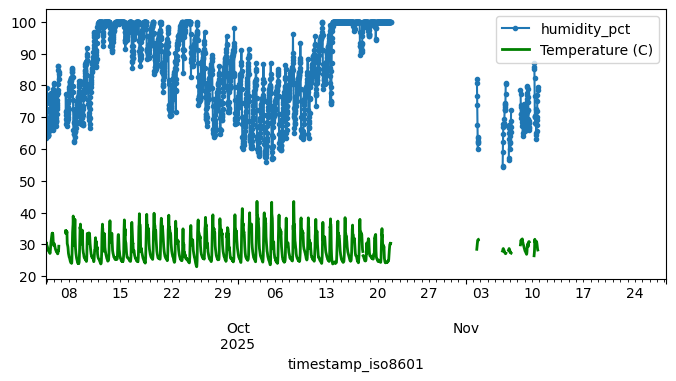

In [18]:
# Plotting
import matplotlib.pyplot as plt

# The last 5-day period
ax = df["humidity_pct"].plot(grid=True, marker='.', figsize=(8, 3.5))

df["temperature_c"].plot(
    ax=ax, color='green', linewidth=2, label="Temperature (C)"
)

# Add a legend to distinguish them
ax.legend()

In [19]:
# The gaps indicate times the board was off

In [20]:
df = df.interpolate(method="linear")
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4049 entries, 2025-09-04 22:00:00+00:00 to 2025-11-28 06:00:00+00:00
Freq: 30min
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   humidity_pct   4049 non-null   float64
 1   lux_lx         4049 non-null   float64
 2   pressure_pa    4049 non-null   float64
 3   temperature_c  4049 non-null   float64
dtypes: float64(4)
memory usage: 287.2 KB


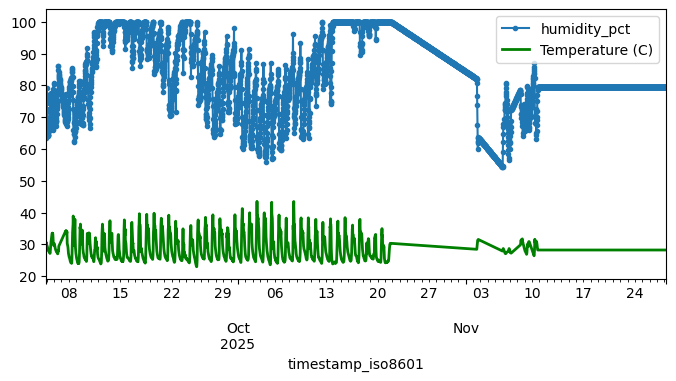

In [21]:
# The last 5-day period
ax = df["humidity_pct"].plot(grid=True, marker='.', figsize=(8, 3.5))

df["temperature_c"].plot(
    ax=ax, color='green', linewidth=2, label="Temperature (C)"
)
# Add a legend to distinguish them
ax.legend()

# Feature Engineering
We include the following features:
1. `sine_hour` - This captures the cyclical nature of the hour of the day. e.g. when taking the sine of the hour of the day, 23:00 is closer to 00:00 as it should be.
2. `cos_hour` - Similar to the above.
3. `temperature_delta` -  The difference between the temperature at the current timestamp and the timestamp immediately before.
4. `temp_mean_6h` - The average temperature over the past 6 hours at this current timestamp.
5. `temp_humidity_6h` - The average humidity over the past 6 hours at this current timestamp.

In [22]:
hour_of_day = df.index.hour
hour_of_day

Index([22, 22, 23, 23,  0,  0,  1,  1,  2,  2,
       ...
        1,  2,  2,  3,  3,  4,  4,  5,  5,  6],
      dtype='int32', name='timestamp_iso8601', length=4049)

In [23]:
import numpy as np

df["sine_hour"] = np.sin(2 * np.pi * hour_of_day / 24)
df["cos_hour"] = np.cos(2 * np.pi * hour_of_day / 24)
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour
timestamp_iso8601,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483,-0.500000,0.866025
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315,-0.500000,0.866025
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943,-0.258819,0.965926
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356,-0.258819,0.965926
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615,0.000000,1.000000


In [24]:
df["delta_temperature"] = df["temperature_c"] - df["temperature_c"].shift(1)
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature
timestamp_iso8601,,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483,-0.500000,0.866025,NaN
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315,-0.500000,0.866025,0.174832
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943,-0.258819,0.965926,2.232628
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356,-0.258819,0.965926,-0.260587
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615,0.000000,1.000000,-0.584741


In [25]:
# Since the first row will be null, we fill it with the mean for this column
df['delta_temperature'].fillna(df['delta_temperature'].mean(), inplace=True)
df.head()

/tmp/ipython-input-1216042316.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['delta_temperature'].fillna(df['delta_temperature'].mean(), inplace=True)


,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature
timestamp_iso8601,,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483,-0.500000,0.866025,0.000018
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315,-0.500000,0.866025,0.174832
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943,-0.258819,0.965926,2.232628
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356,-0.258819,0.965926,-0.260587
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615,0.000000,1.000000,-0.584741


In [26]:
df["temp_mean_6h"] = df["temperature_c"].rolling(window=12, min_periods=1).mean()
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h
timestamp_iso8601,,,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483,-0.500000,0.866025,0.000018,28.172483
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315,-0.500000,0.866025,0.174832,28.259899
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943,-0.258819,0.965926,2.232628,29.033247
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356,-0.258819,0.965926,-0.260587,29.354774
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615,0.000000,1.000000,-0.584741,29.430743


In [27]:
df["humidity_mean_6h"] = df["humidity_pct"].rolling(window=12, min_periods=1).mean()
df.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h,humidity_mean_6h
timestamp_iso8601,,,,,,,,,
2025-09-04 22:00:00+00:00,63.341935,26.594607,100973.617845,28.172483,-0.500000,0.866025,0.000018,28.172483,63.341935
2025-09-04 22:30:00+00:00,69.947520,42.181484,100969.579486,28.347315,-0.500000,0.866025,0.174832,28.259899,66.644727
2025-09-04 23:00:00+00:00,75.398518,97.414887,100973.551907,30.579943,-0.258819,0.965926,2.232628,29.033247,69.562658
2025-09-04 23:30:00+00:00,76.887413,97.793978,101008.485453,30.319356,-0.258819,0.965926,-0.260587,29.354774,71.393847
2025-09-05 00:00:00+00:00,79.289795,97.822113,101026.242403,29.734615,0.000000,1.000000,-0.584741,29.430743,72.973036


## Normalizing

In [28]:
df.describe()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h,humidity_mean_6h
count,4049.000000,4049.000000,4049.000000,4049.000000,4.049000e+03,4.049000e+03,4049.000000,4049.000000,4049.000000
mean,83.493887,2905.814761,101082.297790,28.855235,1.501140e-03,3.027823e-03,0.000018,28.856240,83.480557
std,11.665479,5453.696736,140.640369,3.110416,7.068665e-01,7.075135e-01,0.751229,2.627453,11.391326
min,54.362780,0.000000,100635.793644,22.989888,-1.000000e+00,-1.000000e+00,-4.365562,23.692777,54.666894
25%,77.813200,0.000000,100995.408628,26.826022,-7.071068e-01,-7.071068e-01,-0.145550,27.432968,77.366757
50%,80.726784,17.722978,101097.506263,28.246843,1.224647e-16,6.123234e-17,-0.003346,28.246843,80.438336
75%,94.243764,3828.153688,101155.764049,29.993168,7.071068e-01,7.071068e-01,0.000000,30.065108,93.902866
max,100.000000,28891.834070,101492.141722,43.539995,1.000000e+00,1.000000e+00,4.937021,39.408742,100.000000


In [29]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[df.select_dtypes(include='number').columns] = scaler.fit_transform(
    df.select_dtypes(include='number')
)

In [30]:
df.describe()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h,humidity_mean_6h
count,4.049000e+03,4.049000e+03,4.049000e+03,4.049000e+03,4.049000e+03,4.049000e+03,4.049000e+03,4.049000e+03,4.049000e+03
mean,-7.019439e-18,5.615551e-17,8.249245e-14,-2.597193e-16,-3.421977e-17,3.948435e-18,4.935543e-18,1.551296e-15,-2.737581e-16
std,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00,1.000124e+00
min,-2.497515e+00,-5.328814e-01,-3.175186e+00,-1.885944e+00,-1.416993e+00,-1.417855e+00,-5.811971e+00,-1.965440e+00,-2.529751e+00
25%,-4.870258e-01,-5.328814e-01,-6.178873e-01,-6.524735e-01,-1.002587e+00,-1.003829e+00,-1.937970e-01,-5.417594e-01,-5.367729e-01
50%,-2.372337e-01,-5.296313e-01,1.081507e-01,-1.956223e-01,-2.123916e-03,-4.280056e-03,-4.479083e-03,-2.319630e-01,-2.670977e-01
75%,9.216257e-01,1.691427e-01,5.224342e-01,3.658912e-01,9.983395e-01,9.952686e-01,-2.445579e-05,4.601480e-01,9.150468e-01
max,1.415129e+00,4.765433e+00,2.914487e+00,4.721740e+00,1.412745e+00,1.409295e+00,6.572714e+00,4.016744e+00,1.450356e+00


# Creating the Datasets used by the Model

## Define Input Window Size and Prediction Window Size
We want to use the previous 24 hours of data to predict the next 12 hours of temperatures.

In [31]:
sample_size_in_hrs = 0.5 # we resampled to 30-min chunks
window_size_in_hrs = 24

# since each instance is a 30-min period, and we want a 24hr window
seq_length = int(window_size_in_hrs / sample_size_in_hrs)

## Train, Test Split
We use 80% of the data to train. Then the remaining 20% is then split into equal 10% segments. **No shuffling is done as the time series data needs to stay in chronological order**.

In [32]:
from sklearn.model_selection import train_test_split

# First split: 80% and 20%
df_train, df_temp = train_test_split(df, test_size=0.2,
                                     random_state=42, shuffle=False)

# Second split: split the remaining 20% into two 10% parts
df_valid, df_test = train_test_split(df_temp, test_size=0.5,
                                     random_state=42, shuffle=False)

print(f"Train: {len(df_train)}")
print(f"Valid: {len(df_valid)}")
print(f"Test: {len(df_test)}")


Train: 3239
Valid: 405
Test: 405


In [33]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3239 entries, 2025-09-04 22:00:00+00:00 to 2025-11-11 09:00:00+00:00
Freq: 30min
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   humidity_pct       3239 non-null   float64
 1   lux_lx             3239 non-null   float64
 2   pressure_pa        3239 non-null   float64
 3   temperature_c      3239 non-null   float64
 4   sine_hour          3239 non-null   float64
 5   cos_hour           3239 non-null   float64
 6   delta_temperature  3239 non-null   float64
 7   temp_mean_6h       3239 non-null   float64
 8   humidity_mean_6h   3239 non-null   float64
dtypes: float64(9)
memory usage: 253.0 KB


In [34]:
df_train.head()

,humidity_pct,lux_lx,pressure_pa,temperature_c,sine_hour,cos_hour,delta_temperature,temp_mean_6h,humidity_mean_6h
timestamp_iso8601,,,,,,,,,
2025-09-04 22:00:00+00:00,-1.727699,-0.528004,-0.772846,-0.219532,-0.709558,1.219912,-1.127669e-19,-0.260268,-1.768109
2025-09-04 22:30:00+00:00,-1.161379,-0.525146,-0.801564,-0.163317,-0.709558,1.219912,2.327325e-01,-0.226993,-1.478134
2025-09-04 23:00:00+00:00,-0.694045,-0.515017,-0.773315,0.554563,-0.368319,1.361129,2.972311e+00,0.067377,-1.221949
2025-09-04 23:30:00+00:00,-0.566397,-0.514948,-0.524895,0.470774,-0.368319,1.361129,-3.469486e-01,0.189764,-1.061176
2025-09-05 00:00:00+00:00,-0.360432,-0.514942,-0.398622,0.282756,-0.002124,1.409295,-7.784999e-01,0.218681,-0.922528


## Converting DataFrames to Timeseries Datasets

In [35]:
import tensorflow as tf

In [36]:
def split_inputs_and_targets(
    multivariable_series,
    ahead=24, # the next 24 30-minute time slots (12 hours)
    target_col=3):
  return multivariable_series[:, :-ahead], multivariable_series[:, -ahead:, target_col]

In [37]:
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 24,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

train_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, None, 9), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>

In [38]:
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 24,
    batch_size=32
).map(split_inputs_and_targets)
valid_ds

<_MapDataset element_spec=(TensorSpec(shape=(None, None, 9), dtype=tf.float64, name=None), TensorSpec(shape=(None, None), dtype=tf.float64, name=None))>

# Build and Compile the Model

## I Should Use Keras Tuner here once i get the base model to run

## Definition

In [39]:
# model = tf.keras.Sequential([
#     tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=(48, 9)),
#     tf.keras.layers.SimpleRNN(32),
#     tf.keras.layers.Dense(24)
# ])

In [40]:
# early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae",
#                                                              patience=10,
#                                                              restore_best_weights=True)
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)

In [41]:
# model.compile(
#     loss=tf.keras.losses.Huber(),
#     optimizer=optimizer,
#     metrics=["mae"]
# )

## Training

In [42]:
# history = model.fit(
#     train_ds, validation_data=valid_ds,
#     epochs=500, callbacks=[early_stopping_cb]
# )

## Using Keras Tuner to Find Optimal Hyperparameters

In [43]:
!pip install keras_tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 5.9 MB/s eta 0:00:00


In [44]:
import keras_tuner as kt

def build_model(hp):
    n_hidden = hp.Int('n_hidden', min_value=0, max_value=3, default=2)
    n_neurons = hp.Int('n_neurons', min_value=16, max_value=64)
    learning_rate = hp.Float('learning_rate', min_value=1e-4,
                           max_value=1e-2, sampling='log')
    optimizer = hp.Choice('optimizer', values=["sgd", "adam"])
    if optimizer == "sgd":
      optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,
                                          momentum=0.9)
    else:
      optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model = tf.keras.Sequential()

    # Add an Input layer explicitly to define the input shape
    model.add(tf.keras.Input(shape=(48, 9))) # seq_length=48, num_features=9

    # List to hold configurations for the *actual* RNN layers (after the Input layer)
    rnn_layers_configs = []

    # First RNN layer (conceptually, after the Input layer)
    rnn_layers_configs.append({'units': 32})

    # Additional hidden RNN layers
    for _ in range(n_hidden):
        rnn_layers_configs.append({'units': n_neurons})

    # Add RNN layers to the model, setting return_sequences=False only for the last one
    for i, config in enumerate(rnn_layers_configs):
        is_last_rnn = (i == len(rnn_layers_configs) - 1)
        model.add(tf.keras.layers.SimpleRNN(config['units'],
                                            return_sequences=not is_last_rnn))

    # Output layer
    model.add(tf.keras.layers.Dense(24))

    model.compile(
        loss=tf.keras.losses.Huber(),
        optimizer=optimizer,
        metrics=["mae"])

    return model

In [45]:
random_search_tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=5,
    overwrite=True,
    directory="rnn_model",
    project_name="random_search_rnn",
    seed=42
)

In [46]:
random_search_tuner.search(train_ds, epochs=20, validation_data=valid_ds)

Trial 5 Complete [00h 01m 15s]
val_mae: 0.29771721363067627

Best val_mae So Far: 0.11258165538311005
Total elapsed time: 00h 07m 15s


In [52]:
model = random_search_tuner.get_best_models(num_models=1)[0]
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 48, 32)         │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 27)             │         1,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │           672 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,636 (14.20 KB)

 Trainable params: 3,636 (14.20 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
best_trial = random_search_tuner.oracle.get_best_trials(num_trials=1)[0]
best_trial.summary()

Trial 2 summary
Hyperparameters:
n_hidden: 1
n_neurons: 27
learning_rate: 0.00905127409782462
optimizer: adam
Score: 0.11258165538311005


# Training the Best Model Found by the Tuner

# Using the Model to Make Predictions

In [53]:
def predict_12_hours(model, input_df, seq_length, start_idx, target_col_name,
                     target_col_idx, window_size_in_hrs, scaler):
  X = input_df.to_numpy()[np.newaxis, start_idx:start_idx+seq_length]
  print(f"Shape of Input Data: {X.shape}")

  Y_pred = model.predict(X)[0]
  print(f"Model's Original Prediction (Normalized): {Y_pred}")

  actual_next_12_hrs = input_df[start_idx+seq_length:
                                start_idx+seq_length+window_size_in_hrs][target_col_name].to_numpy()
  print(f"Actual Next 12 Hours: {actual_next_12_hrs}")

  # Calculating the predictions in degrees celcius
  temp_mean = scaler.mean_[target_col_idx]
  temp_std = scaler.scale_[target_col_idx]

  print(temp_mean, temp_std)

  Y_pred_deg = (Y_pred * temp_std) + temp_mean
  actual_next_12_hr_deg = (actual_next_12_hrs * temp_std) + temp_mean

  for i in range(window_size_in_hrs):
    model_pred_in_deg = Y_pred_deg[i]
    actual_in_deg = actual_next_12_hr_deg[i]
    pred_error = model_pred_in_deg - actual_in_deg

    print(f"{(i+1) * 30} MINUTES INTO THE FUTURE!")
    print(f"Model Prediction: {model_pred_in_deg} degrees celcius.")
    print(f"Actual Value: {actual_in_deg} degrees celcius.")
    print(f"Prediction Error: {pred_error} degrees celcius.")
    print('*'*20)

  return Y_pred_deg, actual_next_12_hr_deg

In [54]:
Y_pred_deg, actual_val_deg = predict_12_hours(model, df_valid, seq_length, 0, "temperature_c",
                 3, window_size_in_hrs, scaler)

Shape of Input Data: (1, 48, 9)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
Model's Original Prediction (Normalized): [-0.03537963 -0.04983372 -0.01789404 -0.06679602 -0.11013645 -0.09768314
 -0.10581261 -0.14384982 -0.14327818 -0.12076712 -0.10968851 -0.10311009
 -0.0672804   0.00131857  0.02317122  0.02048472  0.02733096  0.00048041
 -0.02215737 -0.06353616 -0.02923779 -0.01865927 -0.04005243 -0.05620593]
Actual Next 12 Hours: [-0.19562227 -0.19562227 -0.19562227 -0.19562227 -0.19562227 -0.19562227
 -0.19562227 -0.19562227 -0.19562227 -0.19562227 -0.19562227 -0.19562227
 -0.19562227 -0.19562227 -0.19562227 -0.19562227 -0.19562227 -0.19562227
 -0.19562227 -0.19562227 -0.19562227 -0.19562227 -0.19562227 -0.19562227]
28.855234846423116 3.1100316232373797
30 MINUTES INTO THE FUTURE!
Model Prediction: 28.745203079604153 degrees celcius.
Actual Value: 28.246843388888887 degrees celcius.
Prediction Error: 0.4983596907152652 degrees celcius.
********************
60 MINUTES INTO THE FUTURE!
Model 

# Evaluating the model on the test set

In [55]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 405 entries, 2025-11-19 20:00:00+00:00 to 2025-11-28 06:00:00+00:00
Freq: 30min
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   humidity_pct       405 non-null    float64
 1   lux_lx             405 non-null    float64
 2   pressure_pa        405 non-null    float64
 3   temperature_c      405 non-null    float64
 4   sine_hour          405 non-null    float64
 5   cos_hour           405 non-null    float64
 6   delta_temperature  405 non-null    float64
 7   temp_mean_6h       405 non-null    float64
 8   humidity_mean_6h   405 non-null    float64
dtypes: float64(9)
memory usage: 31.6 KB


In [56]:
test_ds = tf.keras.utils.timeseries_dataset_from_array(
    df_test.to_numpy(),
    targets=None,
    sequence_length=seq_length + 24,  # same as in training
    batch_size=32
).map(split_inputs_and_targets)


In [57]:
results = model.evaluate(test_ds)

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0109 - mae: 0.1129


In [58]:
test_mae = results[1]
test_mae

0.10959608107805252

In [59]:
test_mae_deg = (test_mae * scaler.scale_[3])
test_mae_deg

np.float64(0.34084727793563113)

# Preparing the Model for Deployment on the Embedded Board

## Quantizing, Pruning and Saving the TFLite Model

In [61]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]


# # Fix for TensorArray ops
# converter.target_spec.supported_ops = [
#     tf.lite.OpsSet.TFLITE_BUILTINS,
#     tf.lite.OpsSet.SELECT_TF_OPS
# ]
# converter._experimental_lower_tensor_list_ops = False


# quantized_model = converter.convert()
# with open('quantized_rnn_model.tflite', 'wb') as f:
#   f.write(quantized_model)

Saved artifact at '/tmp/tmpvwlu38t8'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 9), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 24), dtype=tf.float32, name=None)
Captures:
  132409910462800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132409910466256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132409910462224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132409910462608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132409910467024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132409910465680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132409910467216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132409910464720: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [64]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Define a representative dataset for full integer quantization
def representative_dataset():
    for x, y in train_ds.take(100):  # Use a small subset of the training data
        yield [tf.cast(x, tf.float32)] # Yield input data as a list of Tensors

converter.representative_dataset = representative_dataset

# Fix for TensorArray ops as suggested by the error
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False

# Removed inference_input_type and inference_output_type as they are for full integer quantization
# and are causing conflict with SELECT_TF_OPS

quantized_model = converter.convert()
with open('quantized_rnn_model.tflite', 'wb') as f:
  f.write(quantized_model)

Saved artifact at '/tmp/tmpi9d0fh0z'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 48, 9), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 24), dtype=tf.float32, name=None)
Captures:
  132409910462800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132409910466256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132409910462224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132409910462608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132409910467024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132409910465680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132409910467216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132409910464720: TensorSpec(shape=(), dtype=tf.resource, name=None)


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


## Reload the TFLite Model

In [65]:
# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path="quantized_rnn_model.tflite")
interpreter.allocate_tensors()

# Get input and output details (optional)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Model loaded successfully!")
print("Input details:", input_details)
print("Output details:", output_details)

Model loaded successfully!
Input details: [{'name': 'serving_default_keras_tensor:0', 'index': 0, 'shape': array([ 1, 48,  9], dtype=int32), 'shape_signature': array([-1, 48,  9], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall_1:0', 'index': 50, 'shape': array([ 1, 24], dtype=int32), 'shape_signature': array([-1, 24], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [66]:

# Evaluating the size of the tflite model
import os

file_path = "quantized_rnn_model.tflite"
size_in_bytes = os.path.getsize(file_path)
size_in_kb = size_in_bytes / 1024
size_in_mb = size_in_kb / 1024

print(f"Model size: {size_in_bytes} bytes ({size_in_kb:.2f} KB / {size_in_mb:.2f} MB)")


Model size: 25544 bytes (24.95 KB / 0.02 MB)


## Using the TFLite Model to Make a Prediction

In [67]:
# Prepare input (same as Keras)
X = df_valid.to_numpy()[np.newaxis, :seq_length]  # shape: (1, seq_length, features)
X = X.astype(input_details[0]['dtype'])  # match TFLite dtype

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], X)

# Run inference
interpreter.invoke()

# Get prediction
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Prediction:", output_data)

Prediction: [[-0.01966937 -0.01966937  0.01966937 -0.01966937 -0.07867748 -0.05900811
  -0.05900811 -0.09834685 -0.11801623 -0.09834685 -0.07867748 -0.07867748
  -0.03933874  0.01966937  0.03933874  0.03933874  0.03933874  0.01966937
   0.         -0.03933874  0.          0.          0.         -0.03933874]]


## Evaluating the TFLite Model on the Test Dataset

In [68]:

import numpy as np

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

seq_length = 48  # or whatever your window size is
num_features = df_test.shape[1]

# Store predictions and true values
preds = []
trues = []

# Loop through test set windows
for start in range(len(df_test) - seq_length - 24 + 1):  # 24 is your prediction horizon
    X = df_test.to_numpy()[start:start+seq_length]
    X = X[np.newaxis, ...].astype(input_details[0]['dtype'])  # shape: (1, seq_length, features)
    interpreter.set_tensor(input_details[0]['index'], X)
    interpreter.invoke()
    y_pred = interpreter.get_tensor(output_details[0]['index'])[0]  # shape: (24,)
    preds.append(y_pred)
    # True values for the next 24 steps of the target column (e.g., temperature)
    y_true = df_test.iloc[start+seq_length:start+seq_length+24]['temperature_c'].to_numpy()
    trues.append(y_true)


In [69]:

preds = np.array(preds)
trues = np.array(trues)

# If you normalized your data, de-normalize predictions and trues here

mae = np.mean(np.abs(preds - trues))


In [70]:
print(f"TFLite Model Test MAE: {mae}")
print(f"TFLite Model Test MAE Degrees Celcius: {mae * scaler.scale_[3]}")

TFLite Model Test MAE: 0.10468917537028084
TFLite Model Test MAE Degrees Celcius: 0.32558664601221726
